## a)Sparse Autoencoder

In [ ]:
from keras.datasets import cifar10
(x_train,_),(x_test,_)=cifar10.load_data()

In [ ]:
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
num_pixels=x_train.shape[1]*x_train.shape[2]
num_pixels

1024

In [ ]:
x_train=x_train.reshape(len(x_train),num_pixels,3)
x_test=x_test.reshape(len(x_test),num_pixels,3)

In [ ]:
x_train.shape

(50000, 1024, 3)

In [ ]:
x_train.shape[1]

1024

In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Input
from tensorflow.keras import regularizers

In [ ]:
encoding_dim=668 #16384/668 = 24.5 is the compression rate
input_img=keras.Input(shape=(x_train.shape[1],3))
# sparsity constrain add activity_regularizer
encoded=Dense(encoding_dim,activation='relu')(input_img)
encoded=Dense(encoding_dim,activation='relu',activity_regularizer=regularizers.L1(10e-10))(encoded)
decoded=Dense(3,activation='sigmoid')(encoded)
sparse_autoencoder=Model(input_img,decoded)

In [ ]:
sparse_autoencoder.compile(optimizer='adam',loss='mse')

In [ ]:
sparse_autoencoder.fit(x_train,x_train,epochs=1,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

196/196 [==============================] - 69s 348ms/step - loss: 0.0055 - val_loss: 6.0488e-04


In [ ]:
output5=sparse_autoencoder.predict(x_test)

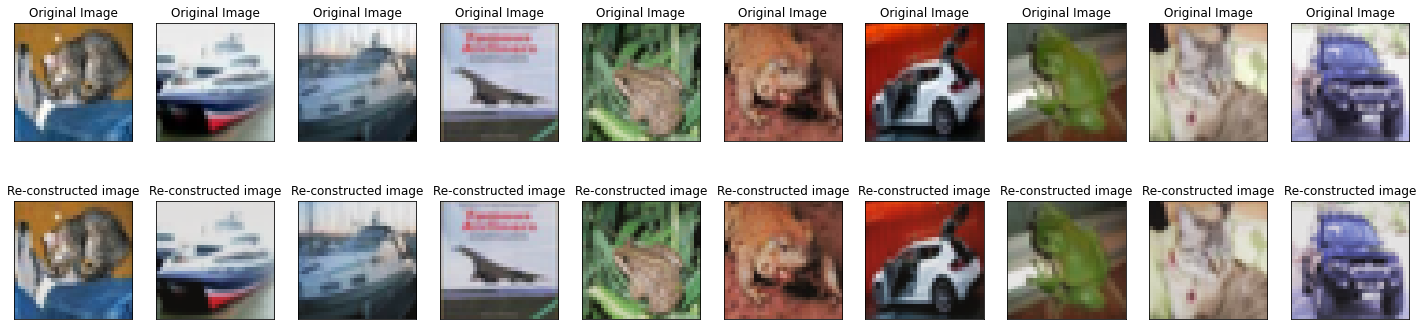

In [ ]:
import matplotlib.pyplot as plt
n=10
plt.figure(figsize=(25,6))
for i in range(n):
  ax=plt.subplot(2,n,i+1)
  plt.title("Original Image")
  plt.imshow(x_test[i].reshape(32, 32, 3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(2,n,i+1+n)
  plt.title("Re-constructed image")
  plt.imshow(output5[i].reshape(32, 32, 3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## b) Convolution autoencoder

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Input
from keras.preprocessing import image
from math import log10,sqrt
from tqdm import tqdm
import numpy as np

In [ ]:
from keras.datasets import cifar10
(x_train,_),(x_test,_)=cifar10.load_data()

In [ ]:
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.

In [ ]:
x_train.shape[1:]

(32, 32, 3)

In [ ]:
input_img=Input(shape=(x_train.shape[1:]))
x=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(input_img)
x=MaxPooling2D(pool_size=(2,2),padding='same')(x)

x=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D(pool_size=(2,2),padding='same')(x)

x=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x)
x=UpSampling2D((2,2))(x)
x=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x)
x=UpSampling2D((2,2))(x)

decoded=Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')(x)

cnn_autoencoder=Model(input_img,decoded)

cnn_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          3692

In [ ]:
cnn_autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
cnn_autoencoder.fit(x_train,x_train,epochs=2,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/2
196/196 [==============================] - 20s 52ms/step - loss: 0.5835 - val_loss: 0.5657
Epoch 2/2
196/196 [==============================] - 9s 47ms/step - loss: 0.5623 - val_loss: 0.5620


In [ ]:
output3=cnn_autoencoder.predict(x_test)

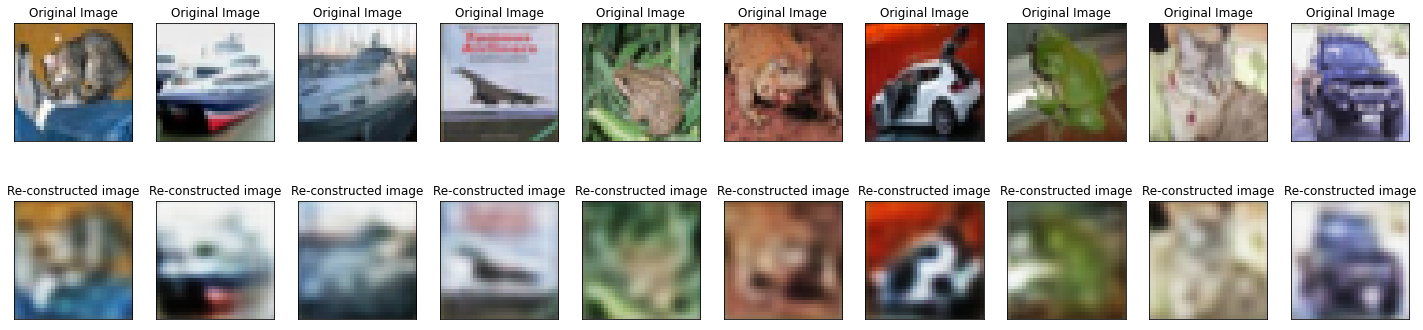

In [ ]:
import matplotlib.pyplot as plt
n=10
plt.figure(figsize=(25,6))
for i in range(n):
  ax=plt.subplot(2,n,i+1)
  plt.title("Original Image")
  plt.imshow(x_test[i].reshape(32, 32, 3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(2,n,i+1+n)
  plt.title("Re-constructed image")
  plt.imshow(output3[i].reshape(32, 32, 3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## C) Denoising Autoencoder

In [ ]:
import numpy as np
noise_factor=0.2
x_train_noisy=x_train+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_train.shape)
x_test_noisy=x_test+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_test.shape)

In [ ]:
x_train_noisy=np.clip(x_train_noisy,0.,1.)
x_test_noisy=np.clip(x_test_noisy,0.,1.)

In [ ]:
from keras.layers import Conv2DTranspose
input_img=Input(shape=(x_train.shape[1:]))
#Encoder
x=Conv2D(64,(3,3),activation='relu',padding='same')(input_img)
x=MaxPooling2D((2,2),padding='same')(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D((2,2),padding='same')(x)
#Decoder
x=Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(x)

x=Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=Conv2D(3,(3,3),activation='sigmoid',padding='same')(x)

denoise_autoencoder=Model(input_img,x)

denoise_autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       9248

In [ ]:
denoise_autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
denoise_autoencoder.fit(x_train_noisy,x_train_noisy,epochs=1,batch_size=128,shuffle=True,validation_data=(x_test_noisy,x_test_noisy))

391/391 [==============================] - 9s 20ms/step - loss: 0.5984 - val_loss: 0.5858


In [ ]:
output4=denoise_autoencoder.predict(x_test_noisy)

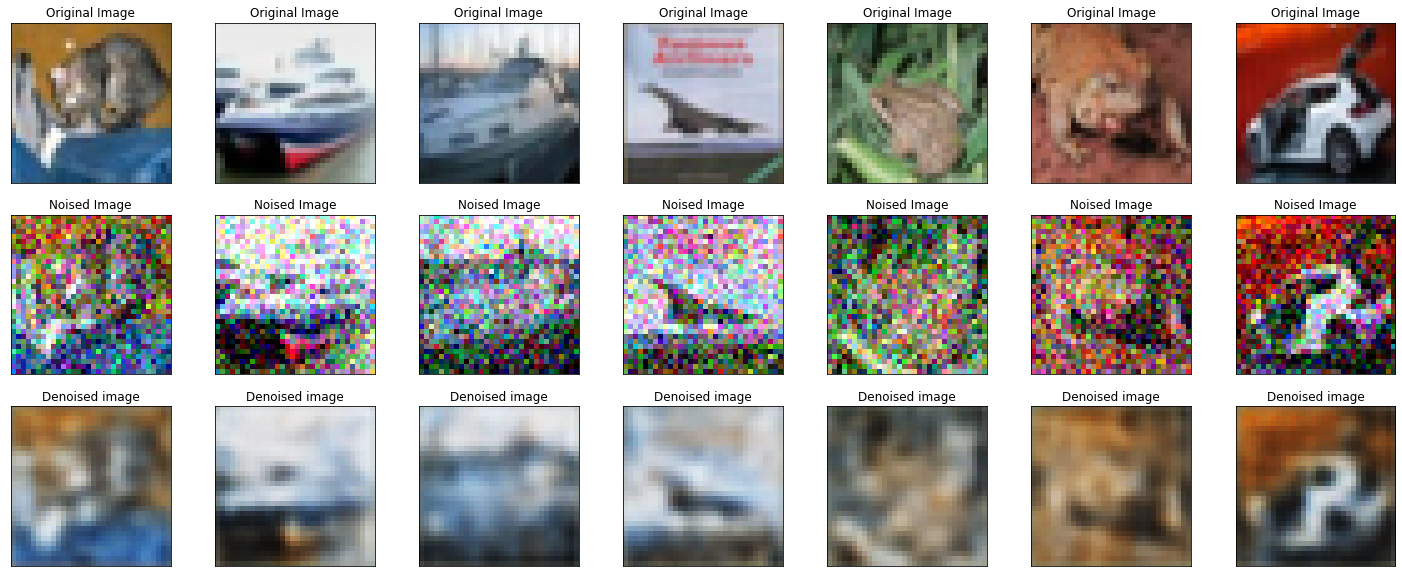

In [ ]:
import matplotlib.pyplot as plt
n=7
plt.figure(figsize=(25,10))
for i in range(n):
  ax=plt.subplot(3,n,i+1)
  plt.title("Original Image")
  plt.imshow(x_test[i].reshape(32,32,3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3,n,i+1+n)
  plt.title("Noised Image")
  plt.imshow(x_test_noisy[i].reshape(32,32,3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3,n,i+1+n+n)
  plt.title("Denoised image")
  plt.imshow(output4[i].reshape(32,32,3))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
